In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
import os
from os import chdir as cd
import warnings
import cv2
from matplotlib import gridspec   
from matplotlib import cm
from scipy import interpolate
from scipy import stats
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import itertools
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Input
import functools
from functools import partial
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy as tCA
from tensorflow.keras.metrics import Recall
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D, Activation, AveragePooling2D , ZeroPadding2D, SeparableConv2D, Dropout, add, Add
from tensorflow.keras.models import Model, load_model , Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalCrossentropy
warnings.filterwarnings("ignore")

In [4]:
cd("/content/drive/Shareddrives/Labs/2020_1_이소연/code")
from lrn import LRN
from f1score import macro_f1score

In [5]:
sub_df = pd.read_pickle("main.pkl")

In [6]:
# Plotting
sw = np.ones((1, 32, 32))
label = list()

for i in tqdm(range(len(sub_df))):
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 32, 32)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
x = sw[1:]
y = np.array(label).reshape((-1,1))

100%|██████████| 8125/8125 [01:20<00:00, 101.40it/s]


Failure type : ['Edge-Loc'] 


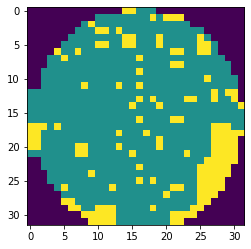

In [ ]:
plt.imshow(x[0])
print('Failure type : {} '.format(y[0]))

In [7]:
labels = ['none','Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch']
for f in labels :
    print('{} : {}'.format(f, len(y[y==f])))

none : 7724
Center : 20
Donut : 2
Edge-Loc : 130
Edge-Ring : 55
Loc : 107
Random : 12
Scratch : 47
Near-full : 28


In [8]:
# For CNN models
new_x = np.zeros((len(x), 32, 32, 3))
for w in range(len(x)):
    for i in range(32):
        for j in range(32):
            new_x[w, i, j, int(x[w, i, j])] = 1
new_x.shape

(8125, 32, 32, 3)

In [9]:
# train/test
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.4, random_state=123)

In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_test[y_test==f])))

none : 3086
Center : 7
Donut : 1
Edge-Loc : 47
Edge-Ring : 23
Loc : 43
Random : 3
Scratch : 25
Near-full : 15


In [ ]:
print('{},{}'.format(x_train.shape, y_train.shape))

(4875, 32, 32, 3),(4875, 1)


In [ ]:
# Convolutional Autoencoder

In [8]:
def encoder(input_img):
    #encoder
    #input = 32 x 32 x 3 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(padding='same')(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(padding='same')(conv2) # 8 x 8 x 64
    return pool2

def decoder(conv4):
    #decoder
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4) # 8 x 8 x 64
    up1 = UpSampling2D()(conv5) # 16 x 16 x 64
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D()(conv6)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 32 x 32 x 1
    return decoded

In [9]:
input_shape = Input(shape=(32, 32, 3))

In [10]:
AEncoder = Model(input_shape, decoder(encoder(input_shape)))
AEncoder.summary()
AEncoder.compile(loss='mse', optimizer='adam')
AEncoder.fit(x_train, x_train, epochs=10, batch_size=64, verbose=2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928 

In [ ]:
np.where(y_test=='Edge-Loc')

(array([  17,  118,  159,  195,  339,  476,  579,  609,  642,  666,  785,
         878, 1026, 1068, 1119, 1208, 1255, 1256, 1341, 1490, 1520, 1616,
        1720, 1766, 1767, 1780, 1897, 2148, 2189, 2190, 2197, 2200, 2323,
        2333, 2336, 2383, 2442, 2445, 2619, 2627, 2637, 2646, 2699, 2739,
        2913, 2954, 3011]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]))

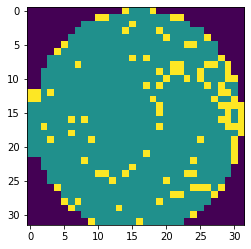

In [ ]:
plt.imshow(np.argmax(x_test[195], axis=2))

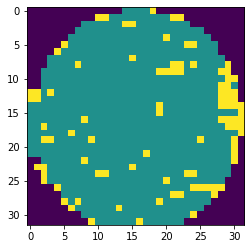

In [ ]:
gen_x = np.argmax(AEncoder.predict(x_test), axis=3)
plt.imshow(gen_x[195])

In [ ]:
x_train[0].shape (4875, 32, 32, 3)

(32, 32, 3)

In [ ]:
np.where(y_train=='Edge-Loc')

(array([ 180,  224,  242,  308,  329,  335,  523,  542,  554,  565,  574,
         633,  766,  816,  899,  901,  927, 1083, 1220, 1421, 1461, 1485,
        1540, 1575, 1627, 1908, 1979, 2027, 2057, 2187, 2289, 2311, 2314,
        2343, 2503, 2518, 2566, 2624, 2667, 2715, 2763, 2784, 2953, 2963,
        3010, 3022, 3046, 3047, 3085, 3397, 3406, 3480, 3558, 3608, 3664,
        3703, 3719, 3750, 3776, 3782, 3789, 3799, 3889, 3891, 3936, 3952,
        3974, 4009, 4048, 4158, 4183, 4334, 4358, 4366, 4505, 4619, 4648,
        4698, 4780, 4785, 4804, 4837, 4858]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

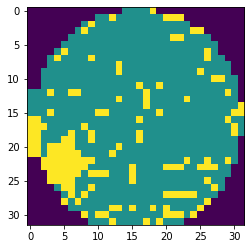

In [ ]:
plt.imshow(np.argmax(x_train[180], axis=2))

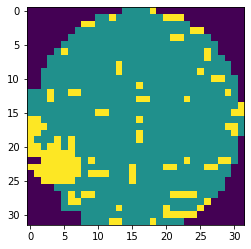

In [ ]:
gen_x = np.argmax(AEncoder.predict(x_train + np.random.normal(loc=0, scale=0.1, size = (4875, 32, 32, 3))), axis=3)
plt.imshow(gen_x[180])

In [11]:
# Generate data
def gen_data(wafer, label):
    gen_x = np.zeros((1, 32, 32, 3))
    
    for i in range((1000//len(wafer)) + 1):
        noised_encoded_x = wafer + np.random.normal(loc=0, scale=0.1, size = (len(wafer), 32, 32, 3))  
        noised_gen_x = AEncoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)

    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x[1:], gen_y[1:]

In [12]:
labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch', 'none']
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

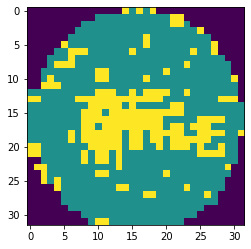

In [ ]:
plt.imshow(np.argmax(x_train[5000], axis=2))

In [ ]:
print('After Generate new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generate new x shape : (9005, 32, 32, 3), new y shape : (9005, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

none : 4638
Center : 520
Donut : 502
Edge-Loc : 664
Edge-Ring : 544
Loc : 576
Random : 513
Scratch : 528
Near-full : 520


In [ ]:
np.unique(y)

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype='<U9')

In [ ]:
np.where(y_test=='Center')

(array([ 133,  409, 1484, 1529, 1790, 2111, 2853]),
 array([0, 0, 0, 0, 0, 0, 0]))

In [13]:
y_OH = OneHotEncoder()
y_ = y_OH.fit_transform(y_train)
print(y_OH.get_feature_names())
y_ = y_.toarray()
print(y_[291])

['x0_Center' 'x0_Donut' 'x0_Edge-Loc' 'x0_Edge-Ring' 'x0_Loc'
 'x0_Near-full' 'x0_Random' 'x0_Scratch' 'x0_none']
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
y_OH2 = OneHotEncoder()
y_2 = y_OH2.fit_transform(y_test)
print(y_OH2.get_feature_names())
y_2 = y_2.toarray()
print(y_2[133])

['x0_Center' 'x0_Donut' 'x0_Edge-Loc' 'x0_Edge-Ring' 'x0_Loc'
 'x0_Near-full' 'x0_Random' 'x0_Scratch' 'x0_none']
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(x_train.shape, y_.shape)

(9005, 32, 32, 3) (9005, 9)


In [15]:
data_name = 'wm811k'
number = '1'
batch_sizes = 128
weight_decay = 1e-4
epochs = 70
model = "AlexNet"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [16]:
def lr_schedule(epoch):
    lr = 3e-4
    if epoch < 30:
        lr = lr
    elif epoch < 60 :
        lr = lr * 0.1
    else:
        lr = lr * 0.01
    print('Learning rate: ', lr)
    return lr

In [ ]:
# 참고 : https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py

def Alexnet(img_shape=(224, 224, 3), n_classes=10, l2_reg=0., weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [ ]:
top5_acc = partial(tCA, k=5)
top5_acc.__name__ = 'top5_acc'

In [ ]:
print(x_train.shape, y_.shape)

(9005, 32, 32, 3) (9005, 9)


In [ ]:
print(x_test.shape, y_2.shape)

(3250, 32, 32, 3) (3250, 9)


In [ ]:
model = Alexnet(img_shape=(32, 32, 3), n_classes=9)
model.summary()
plot_model(model, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=4),
                  LearningRateScheduler(lr_schedule,verbose=1)]
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=[['AUC', 'Precision','Recall']])
auto = model.fit(x_train, y_, validation_data=(x_test, y_2), epochs=50, batch_size=128, callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 256)       0

In [ ]:
model.predict_classes(y_2)

In [31]:
def simple_vgg16():
    input_shape = (32, 32, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = Conv2D(32, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001), activation='relu',padding='same')(input_tensor)
    conv_2 = Conv2D(64, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001), activation='relu',padding='same')(conv_1)
    pool_1 = MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = Conv2D(128, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=l2(0.001), padding='same')(pool_1)
    conv_4 = Conv2D(256, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=l2(0.001), padding='same')(conv_3)
    pool_2 = MaxPool2D((2,2), name = 'max_pool2')(conv_4)

    flat = Flatten()(pool_2)

    dense_1 = Dense(512, activation='relu')(flat)
    drop_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(256, activation='relu')(drop_1)
    output_tensor = Dense(9, activation='softmax')(dense_2)

    model = Model(input_tensor, output_tensor)
 
    return model

In [32]:

model = simple_vgg16()
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=[['AUC', 'Precision','Recall']])
filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)]
auto = model.fit(x_train, y_, validation_data=(x_test, y_2), epochs=50, batch_size=128, callbacks=callbacks_list)

Epoch 1/50
Learning rate:  0.0003

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0003.
102/102 [==============================] - 6s 40ms/step - loss: 1.2059 - auc: 0.9421 - precision: 0.8124 - recall: 0.5621 - val_loss: 0.4812 - val_auc: 0.9963 - val_precision: 0.9726 - val_recall: 0.9406

Epoch 00001: val_loss improved from inf to 0.48120, saving model to /content/drive/Shareddrives/Labs/2020_1_이소연/code/wm811k/model_output/1/model_4/001.h5
Epoch 2/50
Learning rate:  0.0003

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0003.
102/102 [==============================] - 3s 29ms/step - loss: 0.4764 - auc: 0.9950 - precision: 0.9406 - recall: 0.9023 - val_loss: 0.3402 - val_auc: 0.9959 - val_precision: 0.9734 - val_recall: 0.9695

Epoch 00002: val_loss improved from 0.48120 to 0.34019, saving model to /content/drive/Shareddrives/Labs/2020_1_이소연/code/wm811k/model_output/1/model_4/002.h5
Epoch 3/50
Learning rate:  0.0003

Epoch 00003: LearningRateSc

In [39]:
y_predict = model.predict(x_test)

In [40]:
y_pred_ = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred)):
    y_pred_[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test[i])

In [43]:
print(classification_report(y_test_, y_pred_, target_names=labels))

              precision    recall  f1-score   support

        none       1.00      0.00      0.01      3250
      Center       0.00      0.00      0.00         0
       Donut       0.00      0.00      0.00         0
    Edge-Loc       0.00      0.00      0.00         0
   Edge-Ring       0.00      0.00      0.00         0
         Loc       0.00      0.00      0.00         0
      Random       0.00      0.00      0.00         0
     Scratch       0.00      0.00      0.00         0
   Near-full       0.00      0.00      0.00         0

    accuracy                           0.00      3250
   macro avg       0.11      0.00      0.00      3250
weighted avg       1.00      0.00      0.01      3250



In [19]:
def vgg16_model(img_shape=(224, 224, 3), n_classes=1000, l2_reg=0.,
	weights=None):

	# Initialize model
	vgg16 = Sequential()

	# Layer 1 & 2
	vgg16.add(Conv2D(64, (3, 3), padding='same',
		input_shape=img_shape, kernel_regularizer=l2(l2_reg)))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(64, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3 & 4
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(128, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(128, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 5, 6, & 7
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(256, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(256, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(256, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 8, 9, & 10
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 11, 12, & 13
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 14, 15, & 16
	vgg16.add(Flatten())
	vgg16.add(Dense(4096))
	vgg16.add(Activation('relu'))
	vgg16.add(Dropout(0.5))
	vgg16.add(Dense(4096))
	vgg16.add(Activation('relu'))
	vgg16.add(Dropout(0.5))
	vgg16.add(Dense(n_classes))
	vgg16.add(Activation('softmax'))

	if weights is not None:
		vgg16.load_weights(weights)

	return vgg16

def vgg19_model(img_shape=(224, 224, 3), n_classes=1000, l2_reg=0.,
	weights=None):

	# Initialize model
	vgg19 = Sequential()

	# Layer 1 & 2
	vgg19.add(Conv2D(64, (3, 3), padding='same',
		input_shape=img_shape, kernel_regularizer=l2(l2_reg)))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(64, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3 & 4
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(128, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(128, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 5, 6, 7, & 8
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 9, 10, 11, & 12
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 13, 14, 15, & 16
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 17, 18, & 19
	vgg19.add(Flatten())
	vgg19.add(Dense(4096))
	vgg19.add(Activation('relu'))
	vgg19.add(Dropout(0.5))
	vgg19.add(Dense(4096))
	vgg19.add(Activation('relu'))
	vgg19.add(Dropout(0.5))
	vgg19.add(Dense(n_classes))
	vgg19.add(Activation('softmax'))

	if weights is not None:
		vgg19.load_weights(weights)

	return vgg19

In [47]:
model = vgg16_model(img_shape=(32, 32, 3), n_classes=9)
model.summary()
plot_model(model, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model.fit(x_train, y_, validation_data=(x_test, y_2), epochs=50, batch_size=128, callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 34, 34, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 19, 19, 64)        0

In [ ]:
loss=auto.history['loss']
val_loss=auto.history['val_loss']
auc=auto.history['auc']
val_auc=auto.history['val_auc']
precision=auto.history['precision']
val_precision=auto.history['val_precision']
recall=auto.history['recall']
val_recall=auto.history['val_recall']
epochs=range(1,len(loss)+1)

data = np.array([epochs,loss,val_loss,auc,val_auc,precision,val_precision,recall, val_recall]).T

In [48]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [49]:
def plot_confusion_matrix2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [50]:
y_test_pred = model.predict_classes(x_test)
y_test_pred

array([8, 8, 8, ..., 8, 8, 8])

In [51]:
le = LabelEncoder()
y_test_ = le.fit_transform(y_test)
y_test_

array([8, 8, 8, ..., 8, 8, 8])

In [52]:
print(len(y_test_pred),len(y_test_))

3250 3250


In [58]:
labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch', 'none']
print(classification_report(y_test_, y_test_pred, target_names=labels))

              precision    recall  f1-score   support

      Center       0.55      0.86      0.67         7
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.54      0.64      0.58        47
   Edge-Ring       0.75      0.78      0.77        23
         Loc       0.53      0.56      0.55        43
      Random       1.00      1.00      1.00        15
     Scratch       0.67      0.67      0.67         3
   Near-full       0.41      0.36      0.38        25
        none       0.99      0.99      0.99      3086

    accuracy                           0.97      3250
   macro avg       0.60      0.65      0.62      3250
weighted avg       0.97      0.97      0.97      3250



Confusion matrix, without normalization
Normalized confusion matrix


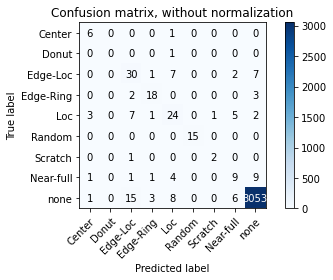

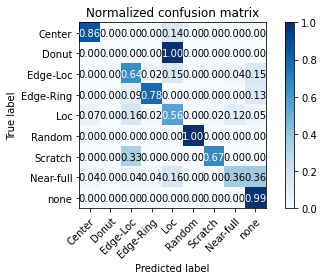

In [59]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix2(y_test_, y_test_pred, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix2(y_test_, y_test_pred, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

In [60]:
model = vgg19_model(img_shape=(32, 32, 3), n_classes=9)
model.summary()
plot_model(model, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model.fit(x_train, y_, validation_data=(x_test, y_2), epochs=50, batch_size=128, callbacks=callbacks_list)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
activation_17 (Activation)   (None, 34, 34, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 19, 19, 64)       

In [61]:
y_test_pred = model.predict_classes(x_test)
y_test_pred

array([8, 8, 8, ..., 8, 8, 8])

In [62]:
le = LabelEncoder()
y_test_ = le.fit_transform(y_test)
y_test_

array([8, 8, 8, ..., 8, 8, 8])

In [63]:
print(len(y_test_pred),len(y_test_))

3250 3250


In [64]:
labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch', 'none']
print(classification_report(y_test_, y_test_pred, target_names=labels))

              precision    recall  f1-score   support

      Center       0.17      0.14      0.15         7
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.83      0.21      0.34        47
   Edge-Ring       0.42      0.35      0.38        23
         Loc       0.40      0.05      0.08        43
      Random       1.00      1.00      1.00        15
     Scratch       0.33      0.33      0.33         3
   Near-full       0.13      0.36      0.19        25
        none       0.99      1.00      0.99      3086

    accuracy                           0.96      3250
   macro avg       0.47      0.38      0.39      3250
weighted avg       0.96      0.96      0.96      3250



Confusion matrix, without normalization
Normalized confusion matrix


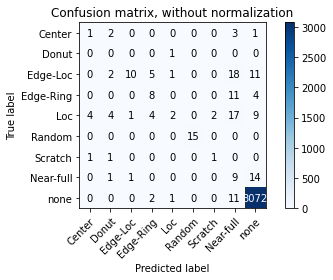

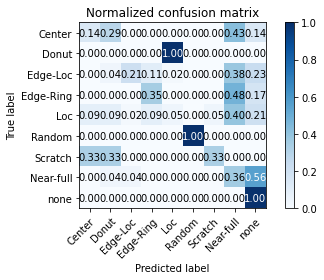

In [66]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_test_pred, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_test_pred, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

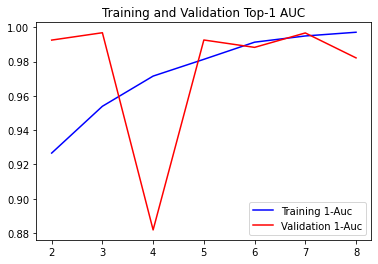

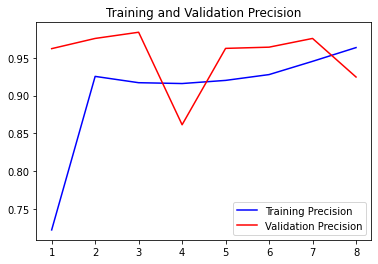

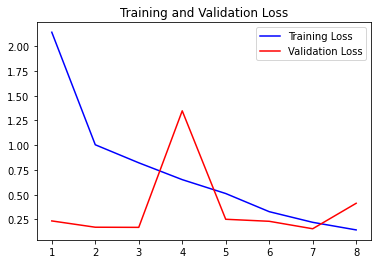

In [ ]:
plt.plot(epochs[1:],auc[1:],'b',label='Training 1-Auc')
plt.plot(epochs[1:],val_auc[1:],'r',label='Validation 1-Auc')
plt.title('Training and Validation Top-1 AUC')
plt.legend()
plt.figure()

plt.plot(epochs,precision,'b',label='Training Precision')
plt.plot(epochs,val_precision,'r',label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [85]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [86]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [93]:
# ResNet50
model = ResNet50(input_shape = (32, 32, 3), classes = 9)
model.summary()
plot_model(model, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model.fit(x_train, y_, validation_data=(x_test, y_2), epochs=30, batch_size=128, callbacks=callbacks_list)

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_30 (ZeroPadding2 (None, 34, 34, 3)    0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1792        zero_padding2d_30[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [94]:
y_predict = model.predict(x_test)

In [95]:
y_pred_ = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred)):
    y_pred_[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test[i])

In [96]:
resmis_index = np.where(pred_decode != resy_test_decode)
print(classification_report(y_test_, y_pred_, target_names=labels))

ValueError: ignored

In [ ]:
labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch', 'none']
print(classification_report(y_test_, y_test_pred, target_names=labels))

              precision    recall  f1-score   support

      Center       0.17      0.14      0.15         7
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.83      0.21      0.34        47
   Edge-Ring       0.42      0.35      0.38        23
         Loc       0.40      0.05      0.08        43
      Random       1.00      1.00      1.00        15
     Scratch       0.33      0.33      0.33         3
   Near-full       0.13      0.36      0.19        25
        none       0.99      1.00      0.99      3086

    accuracy                           0.96      3250
   macro avg       0.47      0.38      0.39      3250
weighted avg       0.96      0.96      0.96      3250



Confusion matrix, without normalization
Normalized confusion matrix


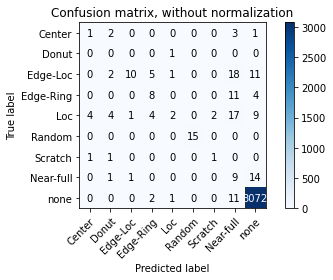

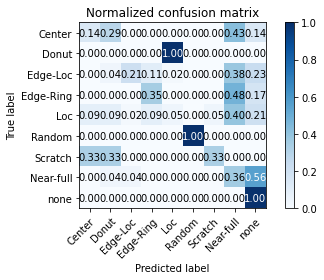

In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_test_pred, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_test_pred, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

In [ ]:
# denoising autoencoder
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noise = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noise = x_test + noise

encoder = Model(input_tensor, latent_vector)
decoder_input = Input((16, 16, 64))
decode = Conv2DTranspose(64, (3,3), padding='same', activation='relu')(decoder_input)
decode = UpSampling2D()(decode)
decoder = Model(decoder_input, output_tensor(decode))

noise = Model(input_tensor, decoder(encoder(input_tensor)))
noise.summary()
noise.compile(loss='mse', optimizer='adam', metrics=['AUC'])
noise.fit(x_train_noise,x_train, validation_data=(x_test_noise, x_test), epochs=10, batch_size=64, callbacks=callback_list)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_1 (Functional)         (None, 16, 16, 64)        1792      
_________________________________________________________________
model_2 (Functional)         (None, 32, 32, 3)         38659     
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
89/89 [==============================] - 4s 35ms/step - loss: 0.0818 - auc: 0.9319 - val_loss: 0.0527 - val_auc: 0.9781
Epoch 2/10
89/89 [==============================] - 3s 31ms/step - loss: 0.0474 - auc: 0.9824 - val_loss: 0.0438 - val_auc: 0.9848
Epoch 3/10
89/89 [==============================] - 3s 31ms/step - loss: 0.0414 - auc: 0.9864 - val_loss: 0.0393 - val_auc:

In [ ]:
np.where(y_test=='Scratch')

(array([ 291,  299,  516,  656,  836, 1657, 1843, 2286, 2341, 2353, 2376]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

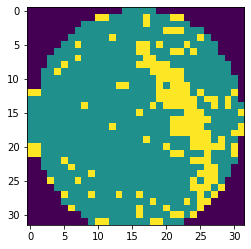

In [ ]:
plt.imshow(np.argmax(x_test[291], axis=2))

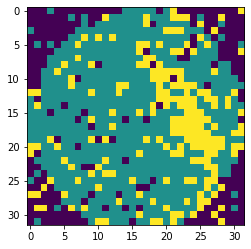

In [ ]:
plt.imshow(np.argmax(x_test_noise[291], axis=2)) 

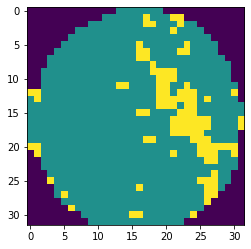

In [ ]:
x_noise = noise.predict(x_test_noise) 
plt.imshow(np.argmax(x_noise[291], axis=2))

In [ ]:
# Generate data
def gen_data(wafer, label):
    encoded_x = encoder.predict(wafer)
    
    gen_x = np.zeros((1, 26, 26, 3))
    
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x[1:], gen_y[1:]

In [ ]:
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

In [ ]:
# Simple CNN 
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)
  
    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

In [ ]:
predicted_classes = simple.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [ ]:
predicted_classes.shape

(2438, 32, 3)

In [ ]:
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

In [ ]:
# mapping_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}

y_train_pred = simple.predict(x_train)
y_test_pred = simple.predict(x_test)

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

In [ ]:
# variational autoencoder
batch_size = 100
original_dim = 128*128
latent_dim = 3
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(128)(x)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(64)(h)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(32)(h)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(32, activation='relu')
decoder_h2 = Dense(64, activation='relu')
decoder_h3 = Dense(128, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
h_decoded = decoder_h3(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

loss_log = []

class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

x_train = load_wafers('clean2_train')
x_train = (x_train + 1) / 2
#x_train = x_train.reshape(x_train.shape[0], 128, 128)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

In [ ]:
vae.fit(x_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size)

In [ ]:
# VGG-16 (Simplified)
ddef VGG16(include_top=True,  pooling=None, classes=9):

    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(input_tensor)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)
    
    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(1028, activation='relu', name='fc1')(x)
        x = layers.Dense(1028, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Create model.
    model = models.Model(input_tensor, x, name='vgg16') 

    return model

In [ ]:
VGG_model = VGG16(include_top=True,  pooling=None, classes=9)
W0_model.summary()
VGG_model.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
VGG_Hist = VGG_model.fit(nsx_train, y_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

In [ ]:
# ResNet50
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform

def identity_block(X, f, filters, stage, block):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def convolutional_block(X, f, filters, stage, block, s = 2):
   
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape = (27, 27, 3), classes = 9):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32,32,128], stage=2, block='b')
    X = identity_block(X, 3, [32,32,128], stage=2, block='c')

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

       # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2), name = "avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = models.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
Rmodel0 = ResNet50(input_shape = (27, 27, 3), classes = 9)
Rmodel0.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
Resnet_hist = Rmodel0.fit(nsx_train, y_train, epochs=30, validation_data=[nx_test, y_test], batch_size = 700, shuffle=True)